In [45]:
import numpy as np
import h5py
import matplotlib
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
import sys
from PIL import Image
sys.path.append('../')
from utils.common_fcns import *

In [3]:
def combine_all_coils(volume_kspace,slice_idx):
    slice_kspace = volume_kspace[slice_idx]
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
    return slice_image_rss.numpy()

In [87]:
def to_jpeg(X,X_true):
    matplotlib.image.imsave('X.jpg', X)
    image = Image.open('X.jpg').convert('L')
    # convert image to numpy array
    X_jpeg = np.asarray(image.getdata()).reshape(image.size)
    X_jpeg = X_jpeg*np.max(X_true)/255
    return X_jpeg

In [39]:
def resize_scan(X):
    # Raw image is a rectangle, crop to be square
    y_min = int((768-396)/2)
    y_max = int((768-396)/2+396)
    X_square = X[y_min:y_max,:]
    # Crop further to zone of interest to get a 256x256 image
    X_square_256 = X_square[50:50+256,70:70+256]
    return X_square_256
    

In [4]:
# Load a scan in
data_dir = '../data/multicoil_test/'
file = data_dir+'file_brain_AXT2_200_2000482.h5'
hf = h5py.File(file)
volume_kspace = hf['kspace'][()]
n_slices = volume_kspace.shape[0]
print('Number of Slices for this file: '+str(n_slices))

Number of Slices for this file: 16


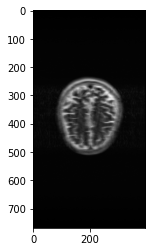

In [40]:
# Pick a slice
X_raw = combine_all_coils(volume_kspace,8)
plt.imshow(np.abs(X_raw), cmap='gray')

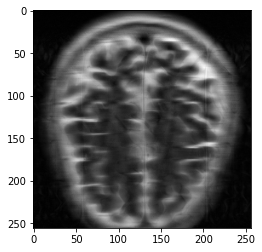

In [51]:
# Resize X for processing
X = resize_scan(X_raw)
plt.imshow(np.abs(X), cmap='gray')

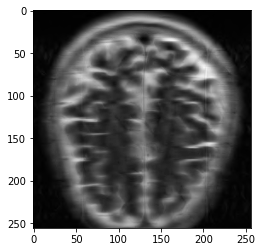

In [42]:
# k-encode and reconstruct
X_encode = k_encode(10000,X)
X_reconstruct = decode(X_encode)
plt.imshow(np.abs(X_reconstruct), cmap='gray')

In [71]:
# Let's try a bunch of k values, and determine loss for each
N = 256*256
K = np.arange(1, N, 10)
error = np.zeros(len(K))
ii = 0
for k in K:
    print('K: '+str(k)+' of '+str(N))
    error[ii] = evaluate_k(k,X)
    ii+=1


K: 1 of 65536
K: 11 of 65536
K: 21 of 65536
K: 31 of 65536
K: 41 of 65536
K: 51 of 65536
K: 61 of 65536
K: 71 of 65536
K: 81 of 65536
K: 91 of 65536
K: 101 of 65536
K: 111 of 65536
K: 121 of 65536
K: 131 of 65536
K: 141 of 65536
K: 151 of 65536
K: 161 of 65536
K: 171 of 65536
K: 181 of 65536
K: 191 of 65536
K: 201 of 65536
K: 211 of 65536
K: 221 of 65536
K: 231 of 65536
K: 241 of 65536
K: 251 of 65536
K: 261 of 65536
K: 271 of 65536
K: 281 of 65536
K: 291 of 65536
K: 301 of 65536
K: 311 of 65536
K: 321 of 65536
K: 331 of 65536
K: 341 of 65536
K: 351 of 65536
K: 361 of 65536
K: 371 of 65536
K: 381 of 65536
K: 391 of 65536
K: 401 of 65536
K: 411 of 65536
K: 421 of 65536
K: 431 of 65536
K: 441 of 65536
K: 451 of 65536
K: 461 of 65536
K: 471 of 65536
K: 481 of 65536
K: 491 of 65536
K: 501 of 65536
K: 511 of 65536
K: 521 of 65536
K: 531 of 65536
K: 541 of 65536
K: 551 of 65536
K: 561 of 65536
K: 571 of 65536
K: 581 of 65536
K: 591 of 65536
K: 601 of 65536
K: 611 of 65536
K: 621 of 65536
K: 

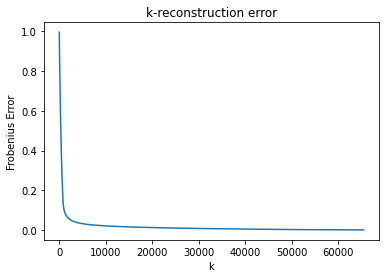

In [70]:
plt.plot(K, error)
plt.xlabel('k')
plt.ylabel('Frobenius Error')
plt.title('k-reconstruction error')
plt.show()

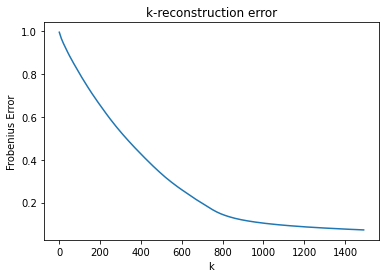

In [92]:
plt.plot(K[:150], error[:150])
plt.xlabel('k')
plt.ylabel('Frobenius Error')
plt.title('k-reconstruction error')
plt.show()

In [84]:
# Compare against the jpeg compressed image
matplotlib.image.imsave('X.jpg', X)
image = Image.open('X.jpg').convert('L')
# convert image to numpy array
X_jpeg = np.asarray(image.getdata()).reshape(image.size)
X_jpeg = X_jpeg*np.max(X)/255
jpeg_error = frob_error(X_jpeg,X)
print(jpeg_error)

0.26306849815374655


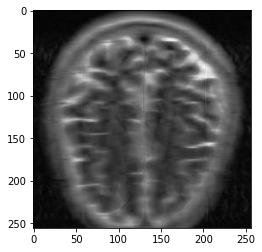

In [61]:
plt.imshow(np.abs(X_jpeg), cmap='gray')

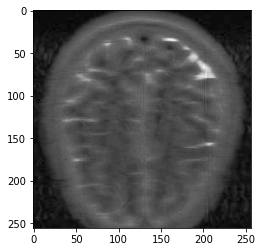

In [90]:
# Illustrating how bad jpeg is, here's perfoming it 3x recursively
X_recursive = X
for ii in range(3):
    X_recursive = to_jpeg(X_recursive,X)

plt.imshow(np.abs(X_recursive), cmap='gray')